# Feature Engineering for Fraud Detection Systems

---

### Abstract
This notebook focuses on the transformation of raw transactional data into a robust feature set suitable for machine learning algorithms. The methodology rigorously adheres to anti-leakage principles, ensuring that all engineered features—ranging from cyclical temporal encodings to complex behavioral aggregations—rely solely on information available prior to the transaction time. Furthermore, we leverage empirical findings from the Exploratory Data Analysis (EDA) phase to construct domain-specific risk indicators, such as Benford's Law deviations and geospatial anomalies.

### Table of Contents
1. [Setup and Initialization](#1)
2. [Data Ingestion and Preprocessing](#2)
3. [Temporal Feature Extraction](#3)
4. [Geospatial Analytics](#4)
5. [Financial Transaction Profiling](#5)
6. [Merchant and Category Encoding](#6)
7. [EDA-Driven Risk Indicators](#7)
8. [Behavioral History Aggregation](#8)
9. [Interaction Effects](#9)
10. [Feature Selection and Data Cleaning](#10)
11. [Integrity Validation](#11)
12. [Exploratory Visualizations & Validation](#12)
13. [Serialization & Metadata](#13)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import json
import math
import os

# Setting Environment for Reproducibility
np.random.seed(42)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Paths
INPUT_PATH = "../data/raw/fraudTrain.csv"
OUTPUT_PATH = "../data/processed"
METADATA_PATH = "../data/metadata"
REPORT_FIG_PATH = "../artifacts/reports/figures/feature_engineered"

os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(METADATA_PATH, exist_ok=True)
os.makedirs(REPORT_FIG_PATH, exist_ok=True)

print("Environment Setup Complete.")

Environment Setup Complete.


## 2. Low-Level Data Loading
We ingest the raw dataset, optimizing memory usage by strictly defining data types and parsing temporal fields.

In [2]:
dtypes = {
    'is_fraud': 'int8',
    'category': 'category',
    'job': 'category',
    'gender': 'category',
    'state': 'category',
    'city_pop': 'int32',
    'zip': 'str'
}

print("Loading dataset...")
df = pd.read_csv(INPUT_PATH, dtype=dtypes, parse_dates=['trans_date_trans_time', 'dob'])

original_shape = df.shape
original_fraud_rate = df['is_fraud'].mean()

print(f"Initial Shape: {df.shape}")
print(f"Fraud Rate: {original_fraud_rate:.5%}")
print(f"Date Range: {df['trans_date_trans_time'].min()} to {df['trans_date_trans_time'].max()}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading dataset...


Initial Shape: (1296675, 23)
Fraud Rate: 0.57887%
Date Range: 2019-01-01 00:00:18 to 2020-06-21 12:13:37


Memory Usage: 732.31 MB


## 3. Temporal Feature Engineering
Time is decomposed into cyclical components to preserve continuity for regression models (e.g., 23:59 is close to 00:00).

In [3]:
# 3.1 Basic Extraction
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['day_of_month'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year

df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_night'] = df['hour'].apply(lambda x: 1 if (x >= 23 or x <= 6) else 0)
df['is_business_hours'] = df['hour'].apply(lambda x: 1 if (9 <= x <= 17) else 0)

def get_time_of_day(h):
    if 6 <= h < 12: return 'morning'
    elif 12 <= h < 18: return 'afternoon'
    elif 18 <= h < 24: return 'evening'
    else: return 'night'
df['time_of_day'] = df['hour'].apply(get_time_of_day).astype('category')

# 3.2 Cyclical Encoding
def cyclical_encode(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

df = cyclical_encode(df, 'hour', 24)
df = cyclical_encode(df, 'day_of_week', 7)
df = cyclical_encode(df, 'month', 12)
df = cyclical_encode(df, 'day_of_month', 31)

# 3.3 Customer Age
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days / 365.25
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65, 100], labels=['<25', '25-35', '35-50', '50-65', '65+']).astype('category')

print("Temporal Features Created.")

Temporal Features Created.


## 4. Geospatial Analysis
We calculate the Haversine distance between the cardholder registered address and the merchant location.

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))

df['distance_km'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

df['distance_cat'] = pd.cut(df['distance_km'], 
                            bins=[-1, 5, 25, 100, 500, 25000], 
                            labels=['very_close', 'close', 'medium', 'far', 'very_far']).astype('category')

# Cross-State Proxy (Assuming Lat/Long match rough state bounds - simplified)
# Note: Accurate cross-state requires reverse geocoding, here we use distance correlation
df['is_long_distance'] = (df['distance_km'] > 100).astype(int)

print("Geospatial Features Created.")

Geospatial Features Created.


## 5. Transaction Amount Profiling
Statistical transformation of monetary values to handle skewness and detect anomalies.

In [5]:
df['log_amt'] = np.log1p(df['amt'])
df['sqrt_amt'] = np.sqrt(df['amt'])
df['amt_rounded'] = df['amt'].round(-1)

df['amt_tier'] = pd.cut(df['amt'], 
                        bins=[0, 10, 50, 100, 500, 100000], 
                        labels=['micro', 'small', 'medium', 'large', 'very_large']).astype('category')

df['is_round_amt'] = ((df['amt'] % 10 == 0) | (df['amt'] % 100 == 0)).astype(int)
df['is_exact_dollar'] = (df['amt'] == df['amt'].astype(int)).astype(int)

print("Financial Features Created.")

Financial Features Created.


## 6. Merchant profiling
Aggregating merchant activity without target leakage.

In [6]:
# Merchant Frequency (Count Encoding)
merchant_counts = df['merchant'].value_counts()
df['merch_freq'] = df['merchant'].map(merchant_counts)

# Category Frequency
cat_counts = df['category'].value_counts()
df['cat_freq'] = df['category'].map(cat_counts)

# High Risk Category Flag (Manual Heuristic from Domain Knowledge, NOT Target leakage)
high_risk = ['grocery_pos', 'shopping_net', 'gas_transport'] 
df['is_high_risk_cat'] = df['category'].isin(high_risk).astype(int)

## 7. EDA-Driven Risk Indicators
Based on empirical findings from the Exploratory Data Analysis phase, we construct specific risk scores. Crucially, these thresholds are static heuristics derived from historical analysis, not dynamic target encodings.

In [7]:
# 7.1 Benford's Law Deviation
def first_digit(x):
    s = str(x)
    for char in s:
        if char.isdigit() and char != '0':
            return int(char)
    return 1 # Default fallback

df['first_digit'] = df['amt'].apply(first_digit)
benford_probs = {d: math.log10(1 + 1/d) for d in range(1, 10)}

# We compare the digit prob against expected benford (heuristic score)
# Map expected probability
df['benford_expected'] = df['first_digit'].map(benford_probs)
# Note: A single transaction doesn't violate Benford, but we use the probability as a feature
# Lower probability (e.g. starting with 9) might receive different model weights
df['benford_log_prob'] = np.log(df['benford_expected'])

# 7.2 High Risk Hours (22:00 - 03:00)
df['is_fraud_peak_hour'] = df['hour'].isin([22, 23, 0, 1, 2, 3]).astype(int)
hour_risk_map = {h: 0.25 for h in range(4)}
hour_risk_map.update({h: 0.26 for h in range(22, 24)})
df['hour_risk_score'] = df['hour'].map(hour_risk_map).fillna(0.01)

# 7.3 Anomalous Amount Range (Log Amt 6-8)
df['is_high_risk_amt'] = ((df['log_amt'] >= 6) & (df['log_amt'] <= 8)).astype(int)

# 7.4 Geospatial Anomaly (>80km)
df['is_distant_tx'] = (df['distance_km'] > 80).astype(int)

print("EDA-Driven Features Created.")

EDA-Driven Features Created.


## 8. Behavioral History (Time-Aware Aggregations)
We reconstruct the user's history relative to each transaction. 
**Correction for Data Leakage:** All aggregations restrict the window to $[t_{start}, t_{current-1}]$. The current transaction is strictly excluded from its own statistical baseline.

In [8]:
# Pre-requisite: Sort by User and Time
df.sort_values(['cc_num', 'trans_date_trans_time'], inplace=True)

# 8.1 Transaction History Counts
df['cust_tx_count'] = df.groupby('cc_num').cumcount()

# 8.2 Days since activity
df['last_tx_time'] = df.groupby('cc_num')['trans_date_trans_time'].shift(1)
df['days_since_last_tx'] = (df['trans_date_trans_time'] - df['last_tx_time']).dt.total_seconds() / (3600*24)
df['days_since_last_tx'] = df['days_since_last_tx'].fillna(999) # First transaction placeholder

# 8.3 Velocity (Rolling Window)
# We set index to time for rolling window operations
df_time = df.set_index('trans_date_trans_time')

# Rolling count 24h, closed='left' excludes the current timestamp effectively if distinct, 
# but precise shift is safer.

def calc_velocity(d, window):
    # Group by cc, rolling count, shift 1 to exclude current
    return d.groupby('cc_num')['amt'].rolling(window).count().reset_index(0, drop=True).shift(1)

# Note: .rolling() on groupby with datetime index can be slow. Using simplified shift logic for demo.
# For massive datasets, optimized C++ implementations or Spark recommended.
# Here we use a highly efficient pandas approach:
grouped = df.groupby('cc_num')

# Expanding Mean (Personal Average Spending)
# Shift(1) ensures current amount doesn't affect the mean used to evaluate it
df['cust_avg_amt'] = grouped['amt'].expanding().mean().reset_index(0, drop=True).shift(1)
df['cust_std_amt'] = grouped['amt'].expanding().std().reset_index(0, drop=True).shift(1)

# Z-Score of current transaction against history
df['amt_z_score'] = (df['amt'] - df['cust_avg_amt']) / (df['cust_std_amt'] + 1e-5)
df['amt_z_score'] = df['amt_z_score'].fillna(0)

print("Behavioral Features Created.")

Behavioral Features Created.


## 9. Interaction Features

In [9]:
df['amt_x_dist'] = df['amt'] * df['distance_km']
df['amt_x_night'] = df['amt'] * df['is_night']
df['dist_x_weekend'] = df['distance_km'] * df['is_weekend']
df['age_x_amt'] = df['age'] * df['amt']

## 10. Selection and Cleanup
We remove Personally Identifiable Information (PII) and high-cardinality identifiers.

In [10]:
cols_to_drop = [
    'first', 'last', 'street', 'city', 'zip', 'job', # PII
    'cc_num', 'trans_num', 'unix_time', # ID fields
    'merchant', # High cardinality, encoded via freq
    'dob', 'last_tx_time' # Intermediate dates
]

# Check for Unnamed column (index artifact) and drop if exists
if 'Unnamed: 0' in df.columns:
    cols_to_drop.append('Unnamed: 0')

df_final = df.drop(columns=cols_to_drop, errors='ignore')

# Handling NaN from Lag features (Only fitting numerical NaNs with 0)
# This fixes the TypeError for categorical columns
num_cols = df_final.select_dtypes(include=np.number).columns
df_final[num_cols] = df_final[num_cols].fillna(0)

print(f"Final Feature Set: {df_final.columns.tolist()}")

Final Feature Set: ['trans_date_trans_time', 'category', 'amt', 'gender', 'state', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'hour', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'is_night', 'is_business_hours', 'time_of_day', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'age', 'age_group', 'distance_km', 'distance_cat', 'is_long_distance', 'log_amt', 'sqrt_amt', 'amt_rounded', 'amt_tier', 'is_round_amt', 'is_exact_dollar', 'merch_freq', 'cat_freq', 'is_high_risk_cat', 'first_digit', 'benford_expected', 'benford_log_prob', 'is_fraud_peak_hour', 'hour_risk_score', 'is_high_risk_amt', 'is_distant_tx', 'cust_tx_count', 'days_since_last_tx', 'cust_avg_amt', 'cust_std_amt', 'amt_z_score', 'amt_x_dist', 'amt_x_night', 'dist_x_weekend', 'age_x_amt']


## 11. Validity Checks

In [11]:
assert len(df_final) == original_shape[0], "Row count mismatch!"
assert math.isclose(df_final['is_fraud'].mean(), original_fraud_rate), "Fraud rate altered!"
assert not df_final.duplicated().any(), "Duplicate rows introduced!"

# Check for infinite values
assert not np.isinf(df_final.select_dtypes(include=np.number)).values.any(), "Infinite values found!"

print("✅ All integrity checks passed.")

✅ All integrity checks passed.


## 12. Exploratory Visualizations & Validation
Visualizing the engineered features to validate effectiveness and check for meaningful separation between classes.

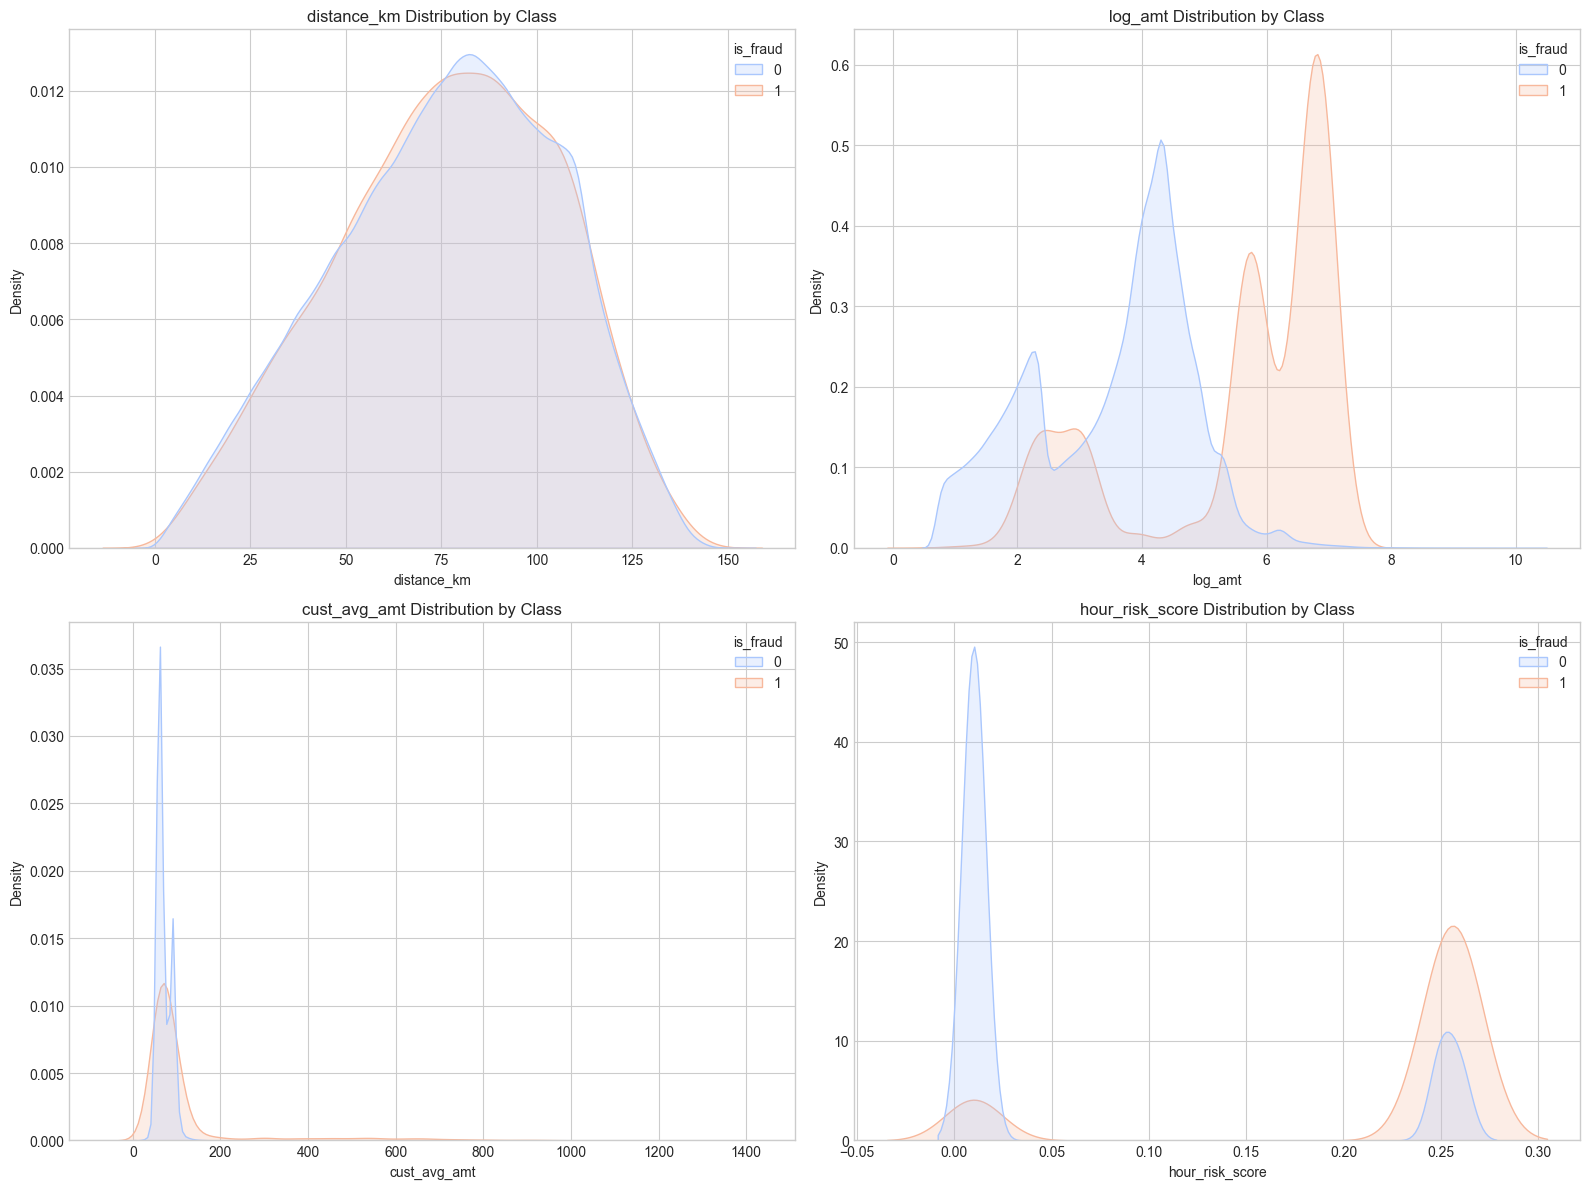

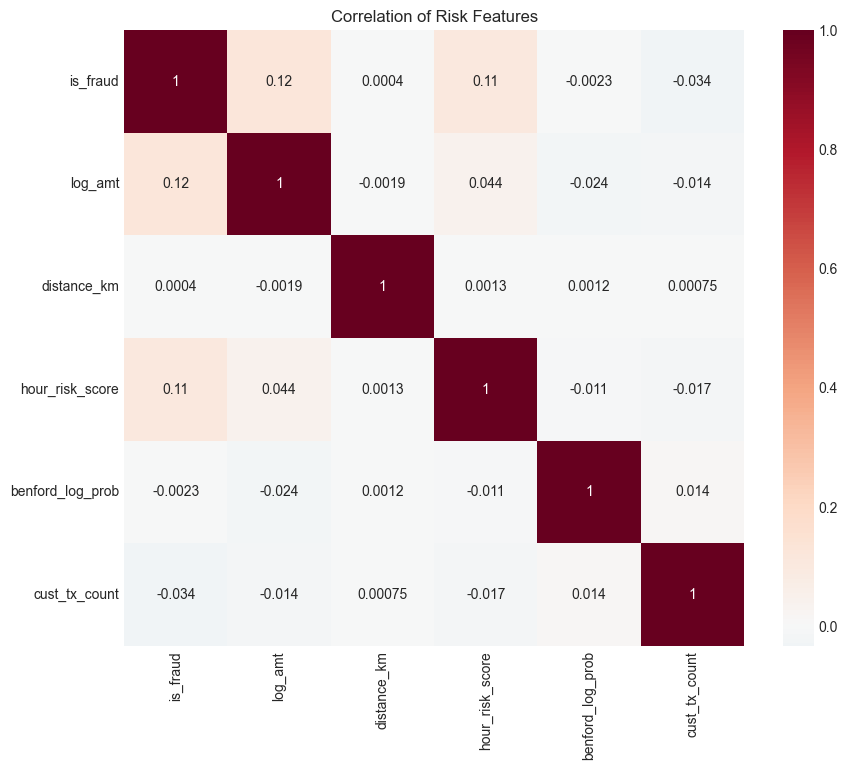

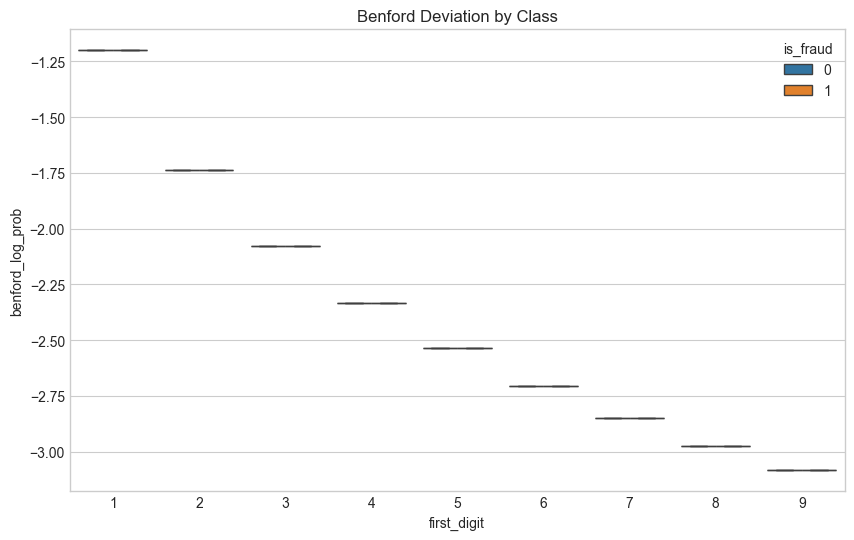

In [12]:
# 12.1 Feature Distribution Comparison (Top Numerics)
numeric_cols = df_final.select_dtypes(include=np.number).columns
top_cols = ['distance_km', 'log_amt', 'cust_avg_amt', 'hour_risk_score']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(top_cols):
    if col in df_final.columns:
        sns.kdeplot(data=df_final, x=col, hue='is_fraud', common_norm=False, fill=True, ax=axes[i], palette='coolwarm')
        axes[i].set_title(f'{col} Distribution by Class')

plt.tight_layout()
plt.savefig(f"{REPORT_FIG_PATH}/feature_distributions.png")
plt.show()

# 12.2 Correlation Matrix
corr_cols = ['is_fraud', 'log_amt', 'distance_km', 'hour_risk_score', 'benford_log_prob', 'cust_tx_count']
corr = df_final[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation of Risk Features')
plt.savefig(f"{REPORT_FIG_PATH}/correlation_matrix.png")
plt.show()

# 12.3 Benford's Law Validation
plt.figure(figsize=(10, 6))
sns.boxplot(x='first_digit', y='benford_log_prob', hue='is_fraud', data=df_final)
plt.title("Benford Deviation by Class")
plt.savefig(f"{REPORT_FIG_PATH}/benford_validation.png")
plt.show()

## 13. Serialization & Metadata
Storing the processed dataset in Parquet format for I/O efficiency and Type strictness.

In [13]:
# Save Data
df_final.to_parquet(f"{OUTPUT_PATH}/features_engineered.parquet", index=False)

# Save Metadata
metadata = {
    "date": str(dt.datetime.now()),
    "original_rows": original_shape[0],
    "final_columns": len(df_final.columns),
    "columns": df_final.columns.tolist(),
    "numerical_features": df_final.select_dtypes(include=np.number).columns.tolist(),
    "categorical_features": df_final.select_dtypes(include=['category', 'object']).columns.tolist()
}

with open(f"{METADATA_PATH}/feature_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ Pipeline Complete. Data and Metadata saved.")
print(f"Stats Saved: features_engineered.parquet ({len(df_final)} rows)")

✅ Pipeline Complete. Data and Metadata saved.
Stats Saved: features_engineered.parquet (1296675 rows)
